In [2]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [4]:
import random
random.seed(0)
torch.manual_seed(0)

In [5]:
# Hyperparameters

LEARNING_RATE = 1e-3
BATCH_SIZE = 8
AUGMENTED_EPOCHS = 40
FINETUNE_EPOCHS = 80
TRAIN_VAL_RATIO = 0.8

DATA_ROOT = '/cluster/home/pvidas/cil_project_data/'
aug_image_dir =   DATA_ROOT + 'mass-data/new_images/'
aug_label_dir =   DATA_ROOT + 'mass-data/new_labels/'
train_image_dir = DATA_ROOT + 'cil-road-segmentation-2022/training/images/'
train_label_dir = DATA_ROOT + 'cil-road-segmentation-2022/training/groundtruth/'
test_image_dir =  DATA_ROOT + 'cil-road-segmentation-2022/test/images/'

In [6]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

def get_all_file_paths(dir):
  filenames = sorted(os.listdir(dir))
  return [os.path.join(dir, filename) for filename in filenames]

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir=None):
        self.image_paths = get_all_file_paths(image_dir)
        self.label_paths = get_all_file_paths(label_dir) if label_dir else None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx], mode=ImageReadMode.RGB) / 255
        if self.label_paths:
            label = read_image(self.label_paths[idx], mode=ImageReadMode.GRAY) / 255
            return image, label
        else:
            return image

In [7]:
from sklearn.metrics import accuracy_score, f1_score
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101
from torchvision.utils import make_grid

class LightningResNet(pl.LightningModule):

  def __init__(self, learning_rate):
    super().__init__()
    self.model = fcn_resnet50(num_classes=1, pretrained_backbone=True)
    self.learning_rate = LEARNING_RATE
  
  def forward(self, x):
    return self.model(x)['out']

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self(x)
    loss = F.binary_cross_entropy_with_logits(y_pred, y)
    self.log('training loss', loss)
    return {'loss': loss}
  
  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self(x)

    if batch_idx == 0:
      batch_size = x.shape[0]
      grid_x = make_grid(x, nrow=batch_size)
      grid_y = make_grid(y, nrow=batch_size)
      grid_y_pred = make_grid(torch.sigmoid(y_pred), nrow=batch_size)
      final_grid = make_grid([grid_x, grid_y, grid_y_pred], nrow=1)
      self.logger.experiment.add_image('validation first batch', final_grid, self.current_epoch)

    y_pred_labels = torch.where(y_pred < 0, 0, 1)
    f1 = f1_score(y.detach().cpu().flatten(), y_pred_labels.detach().cpu().flatten())
    accuracy = accuracy_score(y.detach().cpu().flatten(), y_pred_labels.detach().cpu().flatten())
    self.log('average validation accuracy', accuracy)
    self.log('average validation f1 score', f1)
    return {'accuracy': accuracy, 'f1': f1}
    
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [8]:
model = LightningResNet(learning_rate=LEARNING_RATE)

In [9]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, random_split


def random_split_with_ratio(dataset, ratio):
  len_1 = int(len(dataset) * ratio)
  len_2 = len(dataset) - len_1
  return random_split(dataset, (len_1, len_2))


aug_dataset = CustomDataset(aug_image_dir, aug_label_dir)
aug_train_dataset, aug_val_dataset = random_split_with_ratio(aug_dataset, TRAIN_VAL_RATIO)
aug_train_loader = DataLoader(aug_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
aug_val_loader = DataLoader(aug_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

#trainer = Trainer(fast_dev_run=True)
trainer = Trainer(accelerator='auto', auto_lr_find=True, max_epochs=AUGMENTED_EPOCHS)
trainer.fit(model, aug_train_loader, aug_val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 32.9 M
-------------------------------
32.9 M    Trainable params
0         Non-trainable params
32.9 M    Total params
131.787   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/cluster/home/pvidas/miniconda3/envs/cil/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cluster/home/pvidas/miniconda3/envs/cil/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
dataset = CustomDataset(train_image_dir, train_label_dir)
train_dataset, val_dataset = random_split_with_ratio(dataset, TRAIN_VAL_RATIO)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(accelerator='auto', max_epochs=FINETUNE_EPOCHS, log_every_n_steps=10)
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 32.9 M
-------------------------------
32.9 M    Trainable params
0         Non-trainable params
32.9 M    Total params
131.787   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/cluster/home/pvidas/miniconda3/envs/cil/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cluster/home/pvidas/miniconda3/envs/cil/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
test_dataset = CustomDataset(test_image_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

preds = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cluster/home/pvidas/miniconda3/envs/cil/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 15it [00:00, ?it/s]

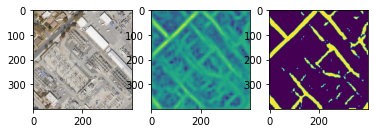

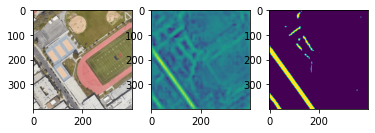

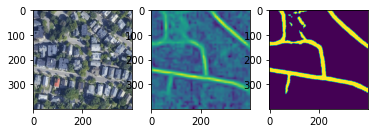

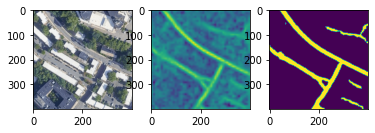

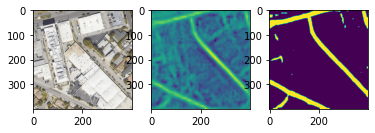

In [15]:
for i in range(5):
    x = test_dataset[i]
    y_pred = preds[i][0]
    y_pred_labels = torch.where(y_pred < 0, 0, 1)

    fig, axs = plt.subplots(ncols=3)
    axs[0].imshow(x.permute(1, 2, 0))
    axs[1].imshow(y_pred.permute(1, 2, 0))
    axs[2].imshow(y_pred_labels.permute(1, 2, 0))
    plt.show()

In [19]:
from torchvision.utils import save_image

test_pred_dir = DATA_ROOT + 'cil-road-segmentation-2022/test/groundtruth/'

for image_path, pred in zip(test_dataset.image_paths, preds):
    file_path = test_pred_dir + image_path.split('/')[-1]
    mask = torch.where(pred[0] < 0, 0.0, 255.0)
    save_image(mask, file_path)